# Differential expression - MOB

In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

from tqdm import tqdm_notebook

In [2]:
sc.set_figure_params(dpi=100)

## Read the data

In [3]:
adata = sc.read('results/hdst-lowres-5x-smooth-0.5sigma.h5ad')
adata

AnnData object with n_obs × n_vars = 35289 × 16208 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    layers: 'smooth_overall'

In [4]:
ad = adata.copy()
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

ad = adata.copy()
ad.X = ad.layers['smooth_overall']
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

11.545544 9.735549
17.007614 12.241791


adata = sc.read('results/others/hdst-D1-lowres-5x-smooth-0.5sigma.h5ad')
adata

ad = adata.copy()
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

ad = adata.copy()
ad.X = ad.layers['smooth_overall']
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

adata = sc.read('results/others/hdst-E1-lowres-5x-smooth-0.5sigma.h5ad')
adata

ad = adata.copy()
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

ad = adata.copy()
ad.X = ad.layers['smooth_overall']
ad._inplace_subset_obs(ad.X.sum(1) > 0.0)
print(ad.X.sum(1).mean(), ad.X.sum(1).std())

In [5]:
del ad

In [6]:
adata.obsm['X_spatial'] = np.array([adata.obs.x, adata.obs.y]).T 

### Remove GM (predicted) genes

In [7]:
import re

gm_genes = adata.var_names[[re.match('Gm[0-9]{2,}', x) is not None for x in adata.var_names]]
gm_genes[:20].values

array(['Gm38393', 'Gm20498', 'Gm5457', 'Gm49342', 'Gm6768', 'Gm9750',
       'Gm16437', 'Gm49405', 'Gm5045', 'Gm20696', 'Gm7879', 'Gm5134',
       'Gm5689', 'Gm7008', 'Gm9762', 'Gm5422', 'Gm11639', 'Gm11992',
       'Gm17018', 'Gm9774'], dtype=object)

In [8]:
adata = adata[:, ~adata.var_names.isin(gm_genes)].copy()
adata

AnnData object with n_obs × n_vars = 35289 × 14041 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    obsm: 'X_spatial'
    layers: 'smooth_overall'

... storing 'region' as categorical


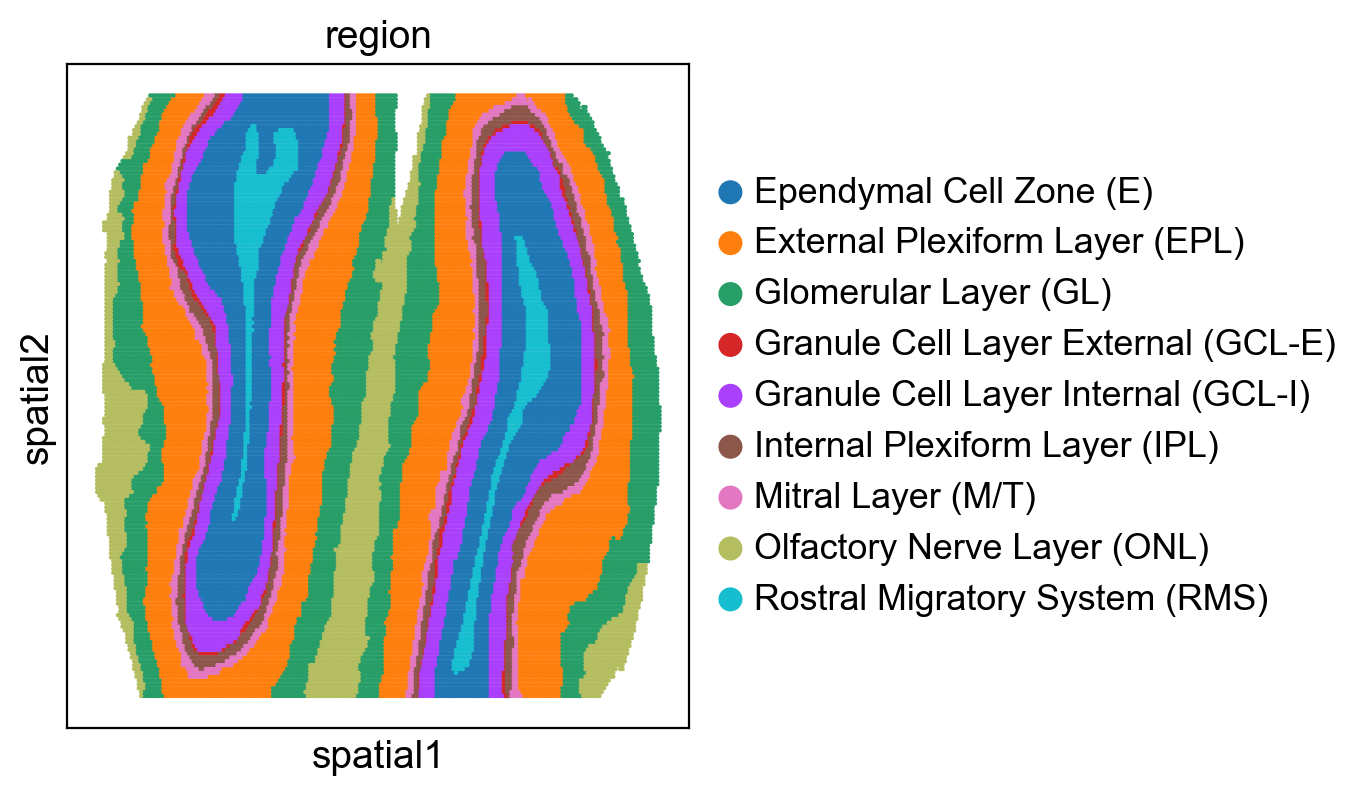

In [9]:
sc.pl.scatter(adata, basis='spatial', color='region', size=10)

Text(0.5, 1.0, 'Total count distributions per-bin')

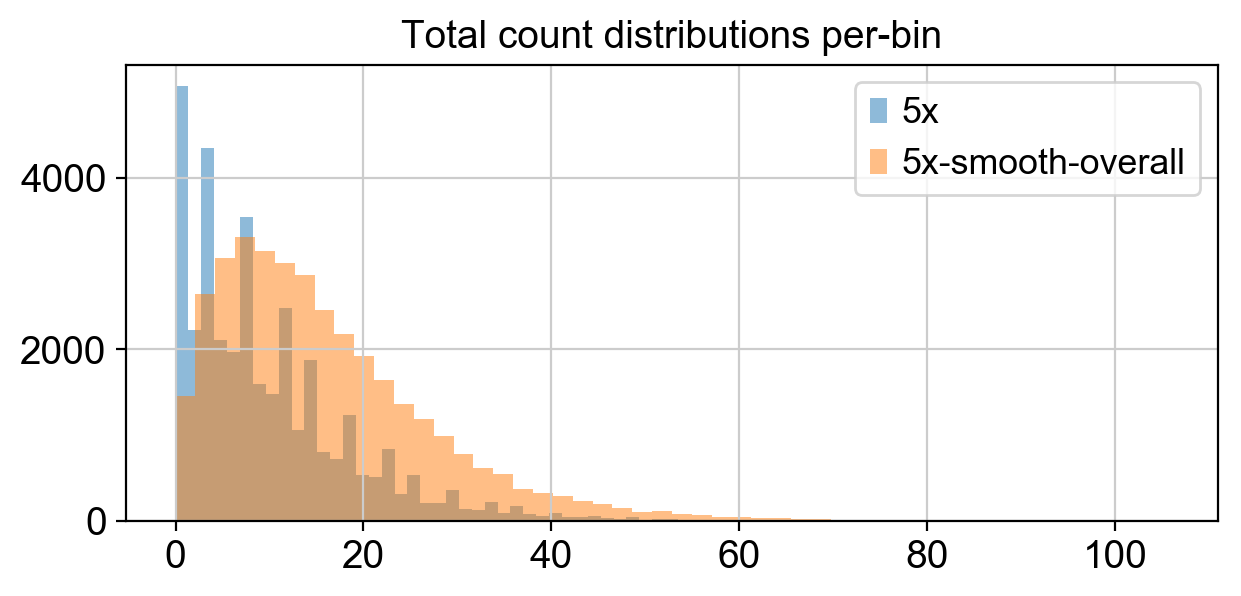

In [10]:
plt.figure(figsize=(7,3))
plt.hist(adata.X.sum(1), bins=70, alpha=0.5);
plt.hist(adata.layers['smooth_overall'].sum(1), bins=50, alpha=0.5);
plt.legend(['5x', '5x-smooth-overall'])
plt.title('Total count distributions per-bin')

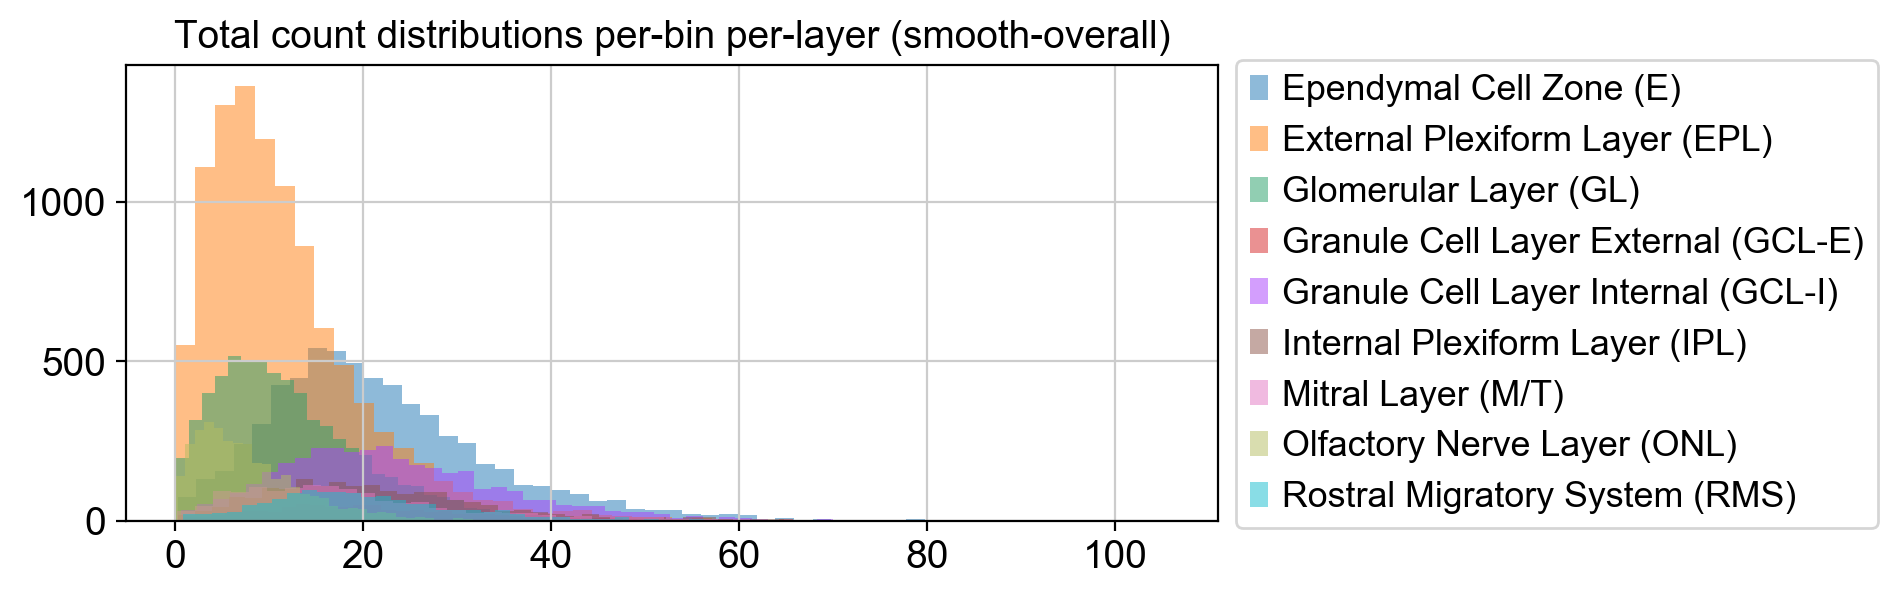

In [11]:
plt.figure(figsize=(7,3))

for c in adata.obs.region.cat.categories:
    plt.hist(adata[adata.obs.region == c].layers['smooth_overall'].sum(1), bins=50, alpha=0.5, label=c);
    plt.title('Total count distributions per-bin per-layer (smooth-overall)')
    plt.legend(loc=0,bbox_to_anchor=(1, 1.05))

# Differential Expression

## Visualization

In [12]:
from statsmodels.stats.multitest import multipletests

def visualize_de(adata, cat_name, 
                 binarize=False,
                 pval_cutoff=0.1,
                 lfc=1.5,
                 std_expression=True, 
                 layer=None, 
                 figsize=(25,6),
                 mean_plot_name=None,
                 pval_plot_name=None):

    ## top genes
    de = tidy_up_scanpy_de_all(adata, cat_name)    
    de = de[(de.pvalsadj <= pval_cutoff) & (de.log2foldchanges > lfc)]
    top_genes = list(set(de.names))
    print('%s DE genes' % len(top_genes))
    assert len(top_genes) < 2000, 'Too many DE genes...'
    
    pvals_adj = tidy_up_scanpy_de(adata, cat_name)    
    pvals_adj_long = pvals_adj
    pvals_adj_long[cat_name] = pvals_adj_long.index
    pvals_adj_long = pvals_adj_long.melt(cat_name, var_name='gene', value_name='pvaladj').sort_values('pvaladj')
    pvals_adj_long = pvals_adj_long[pvals_adj_long.gene.isin(top_genes)].reset_index()

    if layer is None:
        x = adata[:, top_genes].X.toarray()
    else:
        x = adata[:, top_genes].layers[layer]

    if binarize:
        xdf = pd.DataFrame((x > 0).astype(np.float32), columns=top_genes)
    else:
        xdf = pd.DataFrame(x, columns=top_genes)
    
    xdf_mean = xdf.groupby(adata.obs[cat_name].values).mean()
    cm = sns.clustermap(xdf_mean, standard_scale=1 if std_expression else None, cmap='viridis', figsize=figsize, row_cluster=False);
    if mean_plot_name: cm.savefig(mean_plot_name)

    ## P values
    #ridx = cm.dendrogram_row.reordered_ind
    cidx = cm.dendrogram_col.reordered_ind

    pval_mat = pvals_adj.loc[:, top_genes]
    pval_mat[pval_mat == 0.0] = 1e-300
    pval_mat = -np.log10(pval_mat)
    pval_mat[pval_mat<np.log10(pval_cutoff)] = 0
    pval_mat = pval_mat.rename_axis(None, axis=0).rename_axis(None, axis=1)

    cm = sns.clustermap(pval_mat.iloc[:, cidx], cmap='Reds', figsize=figsize, col_cluster=False, row_cluster=False)
    if pval_plot_name: cm.savefig(pval_plot_name)

def tidy_up_scanpy_de_all(ad, groupby):

    dfs = []

    for c in ad.obs[groupby].cat.categories:
        names = pd.DataFrame(ad.uns['rank_genes_groups']['names'][c], columns=['names'])
        
        scores = pd.DataFrame(ad.uns['rank_genes_groups']['scores'][c], columns=['tstat'])
        lfc = pd.DataFrame(ad.uns['rank_genes_groups']['logfoldchanges'][c], columns=['log2foldchanges'])
        pvals = pd.DataFrame(ad.uns['rank_genes_groups']['pvals'][c], columns=['pvals'])

        pvalsadj = pd.DataFrame(ad.uns['rank_genes_groups']['pvals_adj'][c], columns=['pvalsadj'])
        pvalsadj.values[pvalsadj.values > 1.] = 1. # workaround for scanpy bug

        df = pd.concat([names, scores, lfc, pvals, pvalsadj], axis=1)
        df['group'] = c
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['group'] = df['group'].astype('category')
    df = df.rename_axis(None, axis=0).rename_axis(None, axis=1)
    
    return df

    
def tidy_up_scanpy_de(ad, groupby):

    dfs = []

    for c in ad.obs[groupby].cat.categories:
        names = pd.DataFrame(ad.uns['rank_genes_groups']['names'][c], columns=['names'])
        pvalsadj = pd.DataFrame(ad.uns['rank_genes_groups']['pvals_adj'][c], columns=['pvalsadj'])
        pvalsadj.values[pvalsadj.values > 1.] = 1. # workaround for scanpy bug
        df = pd.concat([names, pvalsadj], axis=1)
        df['group'] = c
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['group'] = df['group'].astype('category')
    df = df.rename_axis(None, axis=0).rename_axis(None, axis=1)
    
    return df.pivot_table('pvalsadj', index='names', columns='group').T

## DE for smooth data

In [13]:
adata

AnnData object with n_obs × n_vars = 35289 × 14041 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'
    layers: 'smooth_overall'

In [14]:
%%time

adata_smooth_overall = adata.copy()
adata_smooth_overall.X = adata_smooth_overall.layers['smooth_overall']

adata_smooth_overall._inplace_subset_obs(adata_smooth_overall.X.sum(1) > 0.)
adata_smooth_overall._inplace_subset_var(adata_smooth_overall.X.sum(0) > 0.)

sc.pp.normalize_per_cell(adata_smooth_overall)
sc.pp.log1p(adata_smooth_overall)

sc.tl.rank_genes_groups(adata_smooth_overall, 'region', n_genes=adata_smooth_overall.n_vars)

... storing 'region' as categorical


CPU times: user 1min 12s, sys: 34.5 s, total: 1min 46s
Wall time: 1min 48s


In [15]:
adata

AnnData object with n_obs × n_vars = 35289 × 14041 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'
    layers: 'smooth_overall'

... storing 'region' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


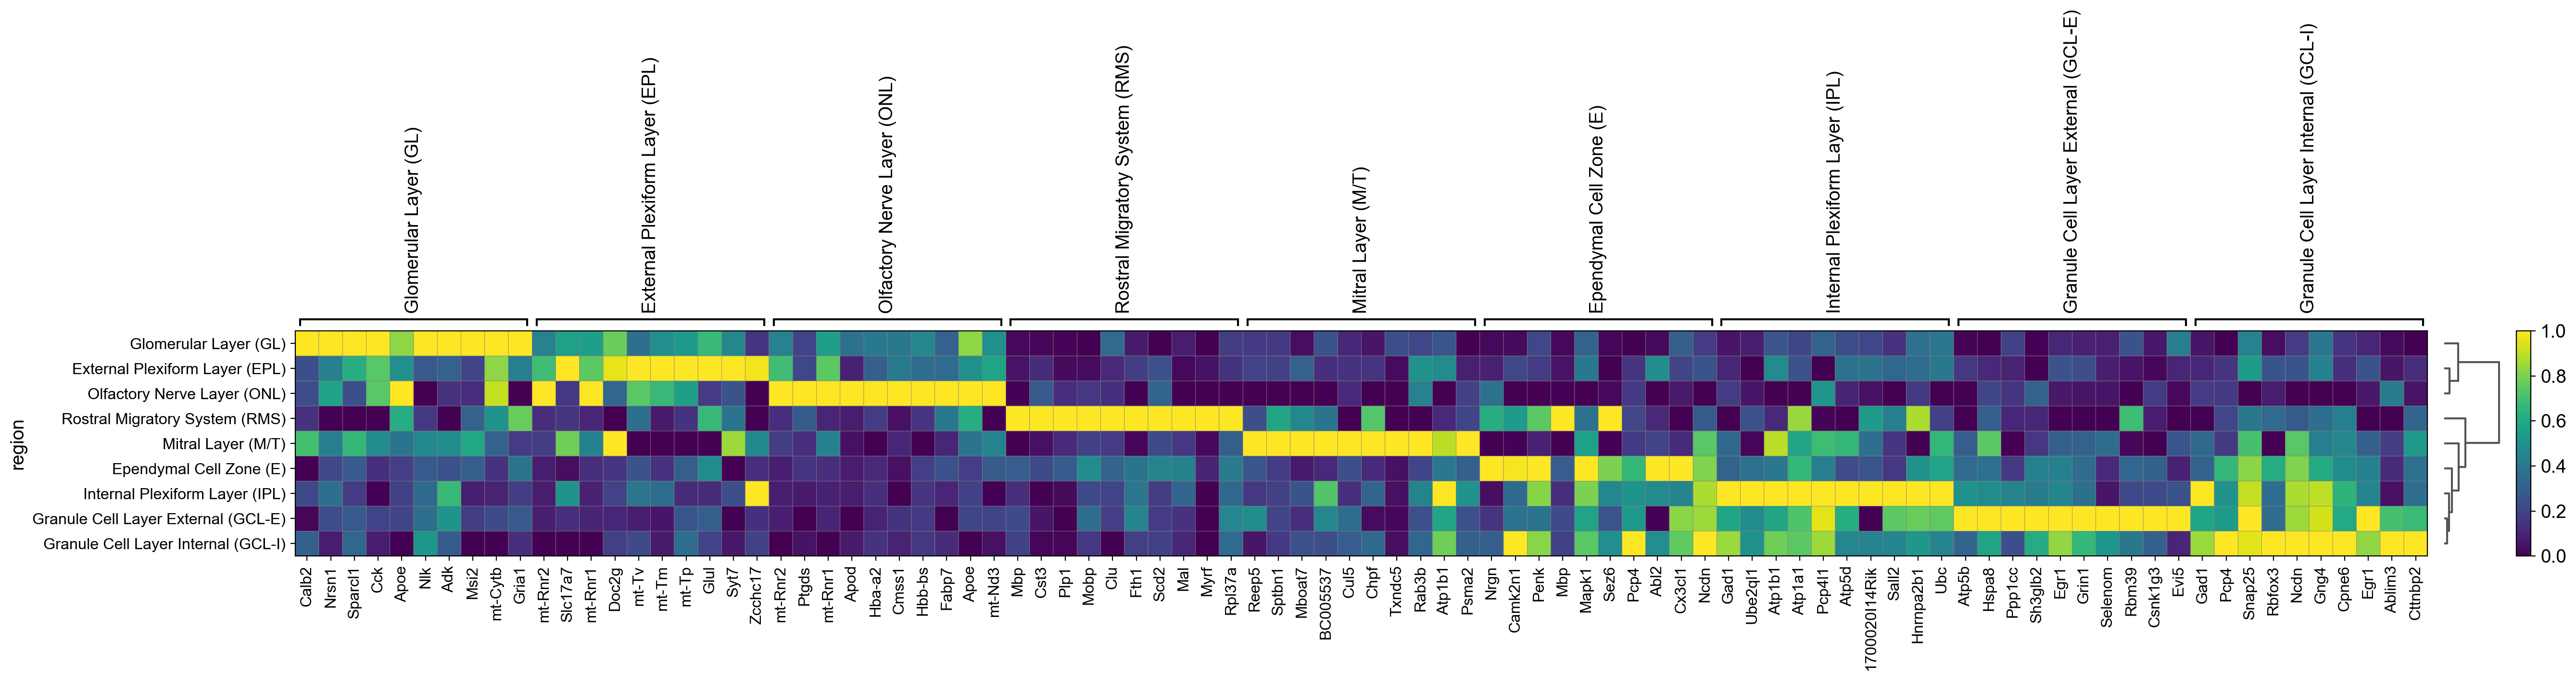

In [17]:
sc.pl.rank_genes_groups_matrixplot(adata_smooth_overall, standard_scale='var')

In [21]:
tidy_up_scanpy_de_all(adata_smooth_overall, 'region').sort_values('pvalsadj').to_excel('results/mob_region_de.xlsx', index=False)